Побудувати CNN на основі LeNet-5 для класифікації зображень на основі
датасету fashion-mnist.
Зробити налаштування моделі для досягнення необхідної точності на базі
Siamese networks побудувати систему для пошуку подібних зображень в
датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
model = keras.Sequential(
    [
        # Перший згортковий шар
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        # Перший шар підвибірки
        layers.AveragePooling2D(),
        # Другий згортковий шар
        layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
        # Другий шар підвибірки
        layers.AveragePooling2D(),
        # Повнозв'язний шар
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        # Повнозв'язний шар
        layers.Dense(units=84, activation='relu'),
        # Вихідний повнозв'язний шар
        layers.Dense(units=10, activation = 'softmax')
    ]
)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 50s 104ms/step - loss: 0.7719 - accuracy: 0.7158 - val_loss: 0.5658 - val_accuracy: 0.7877
Epoch 2/10
422/422 [==============================] - 20s 48ms/step - loss: 0.5171 - accuracy: 0.8074 - val_loss: 0.4851 - val_accuracy: 0.8182
Epoch 3/10
422/422 [==============================] - 22s 52ms/step - loss: 0.4523 - accuracy: 0.8343 - val_loss: 0.4338 - val_accuracy: 0.8392
Epoch 4/10
422/422 [==============================] - 22s 53ms/step - loss: 0.4131 - accuracy: 0.8504 - val_loss: 0.4363 - val_accuracy: 0.8428
Epoch 5/10
422/422 [==============================] - 21s 49ms/step - loss: 0.3866 - accuracy: 0.8587 - val_loss: 0.3985 - val_accuracy: 0.8578
Epoch 6/10
422/422 [==============================] - 22s 52ms/step - loss: 0.3676 - accuracy: 0.8670 - val_loss: 0.3755 - val_accuracy: 0.8645
Epoch 7/10
422/422 [==============================] - 23s 53ms/step - loss: 0.3483 - accuracy: 0.8727 - val_loss: 0.3626 - val_accuracy

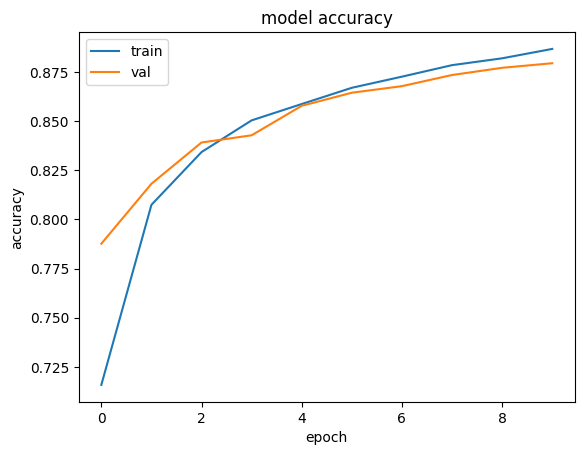

313/313 [==============================] - 2s 6ms/step - loss: 0.3485 - accuracy: 0.8764
Test accuracy: 0.8763999938964844


In [3]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

In [4]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'features')
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()
     

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 features (Concatenate)         (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 16)           336         ['features[1][0]']   

In [5]:
import numpy as np
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_test)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])
     

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [6]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)
     

1/1 [==============================] - 0s 107ms/step


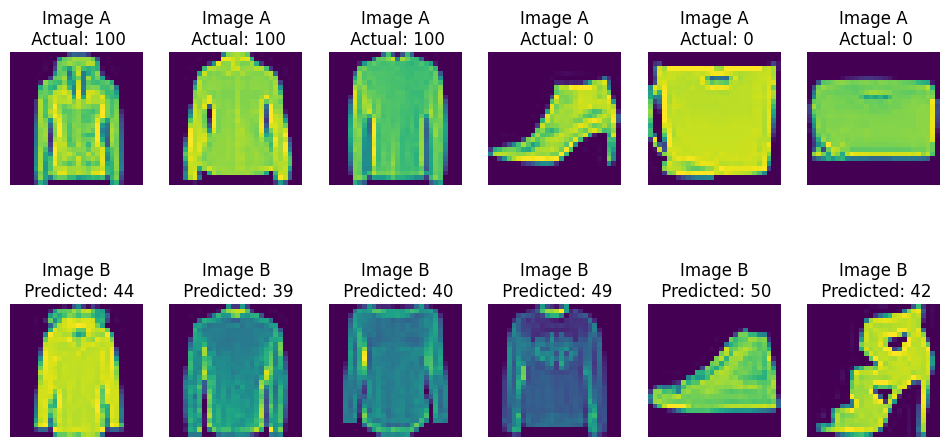

In [7]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [8]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 2,
    verbose = True)

1/1 [==============================] - 0s 29ms/step
Epoch 1/2
500/500 [==============================] - 103s 203ms/step - loss: 0.5611 - mae: 0.3999 - val_loss: 0.4561 - val_mae: 0.3432
Epoch 2/2
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 22ms/step


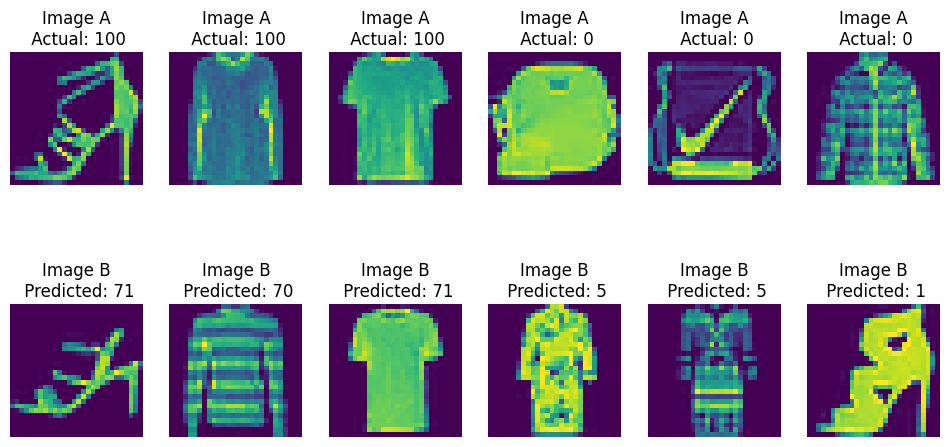

In [9]:
_ = show_model_output()

In [10]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
init='pca',
random_state=101,
method='barnes_hut',
n_iter=500,
verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 1s 16ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 0.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.493s
[t-SNE] Iteration 50: error = 80.4588089, gradient

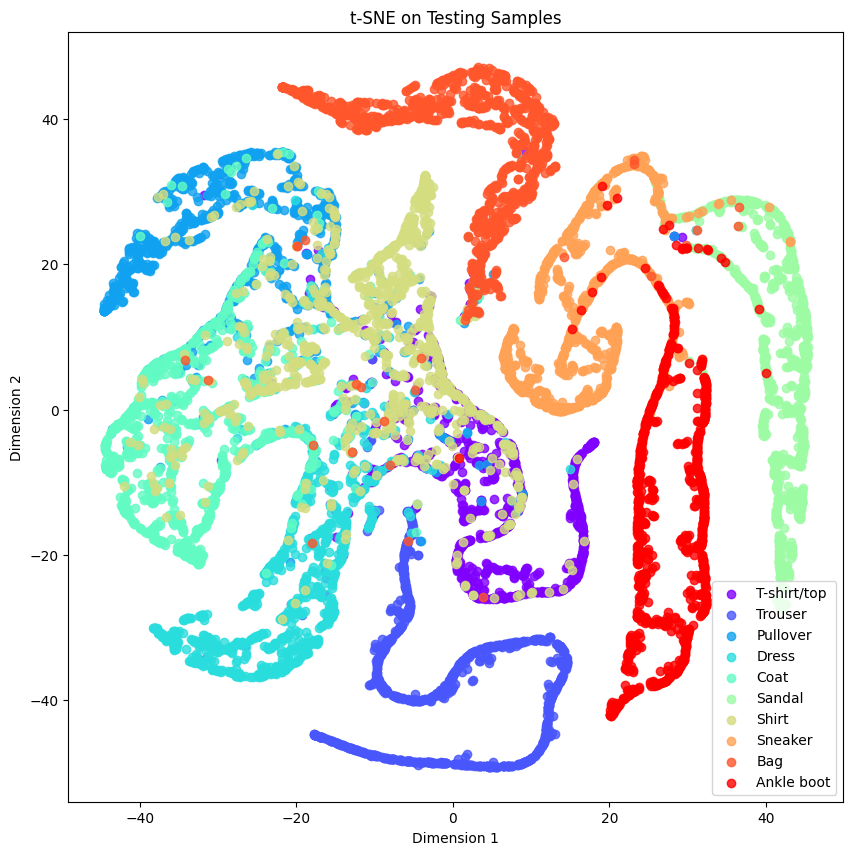

In [11]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)